In [1]:
# load packages
from imutils import face_utils
import imutils
import dlib
import cv2
import glob
import numpy as np
from matplotlib import pyplot as plt
from face_functions import *

In [2]:
# load the images
original_headshot = 'files/headshot.jpg'
image1_name = 'files/headshot_post_nst.jpg'
image2_name = 'files/artistic_portrait.jpg'

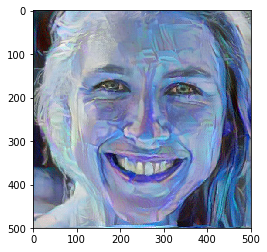

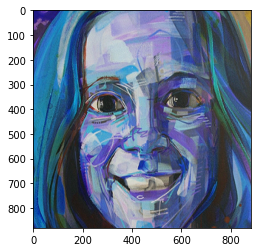

In [3]:
# compute the face cropped file for each image
# headshot photo is already cropped
image1_cropped  = cv2.imread(image1_name,cv2.IMREAD_COLOR)
image1_cropped_shape = np.shape(image1_cropped)
plt.figure()
plt.imshow(image1_cropped)


# crop the artistic image
image2  = cv2.imread(image2_name,cv2.IMREAD_COLOR)
image2_orig = np.copy(image2)
image2_faces, image2_face_detect, image2_cropped, image2_rectangle = compute_face_crop(image2)
image2_cropped_shape = np.shape(image2_cropped)
plt.figure()
plt.imshow(image2_cropped)

In [4]:
# compute the face landmarks
# load the predictor from dlib
p = "files/shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

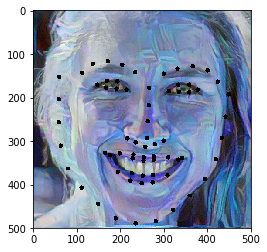

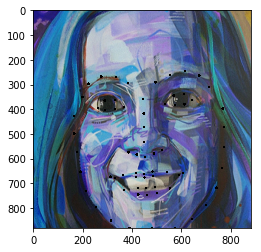

In [5]:
# compute the landmarks in the art and headshot faces
# for the art image
image1_points, image1_points1 = compute_landmarks(image1_cropped,detector,predictor)  

image1_points2 = []
for (x,y) in image1_points:
    if x >= image1_cropped_shape[1]:
        x = image1_cropped_shape[1] -1
    if y >= image1_cropped_shape[0]:
        y = image1_cropped_shape[0] -1
    image1_points2.append((x,y))
image1_points = image1_points2

# add landmarks to image and plot
image1_lm = draw_landmarks(image1_cropped, image1_points)
plt.figure()
plt.imshow(image1_lm)
cv2.imwrite('files/warped_headshot_lm.jpg',image1_lm)

# for the headshot image
image2_points, image2_points1 = compute_landmarks(image2_cropped,detector,predictor)

image2_points2 = []
for (x,y) in image2_points:
    if x >= image2_cropped_shape[1]:
        x = image2_cropped_shape[1] -1
    if y >= image2_cropped_shape[0]:
        y = image2_cropped_shape[0] -1
    image2_points2.append((x,y))
image2_points = image2_points2

# add landmarks to image and plot
image2_lm = draw_landmarks(image2_cropped, image2_points)
plt.figure()
plt.imshow(image2_lm)


In [6]:
# compute the convex hull for each image

hullPoints_image2, hullIndex_image2 = computeHullIndex(image2_points1, image2_points)
hullPoints_image1, hullIndex_image1 = computeHullIndex(image1_points1, image1_points)

# compute the convex hull for one image - corresponds to other
hull_image1 = []
hull_image2 = []
for i in range(0, len(hullIndex_image2)):
    hull_image1.append(image1_points[int(hullIndex_image2[i])])
    hull_image2.append(image2_points[int(hullIndex_image2[i])])

In [7]:
# find the final points for the image to use for triangulation
image1_points_final = hull_image1
image2_points_final = hull_image2

True

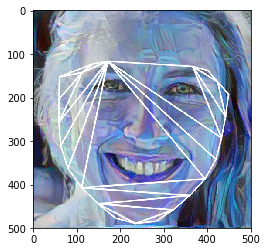

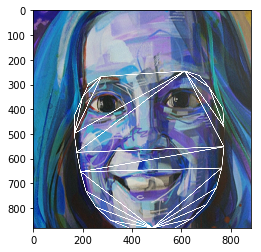

In [8]:
# find the Delaunay Triangulation for each image
dt_image1, image1_triangles = calculateDelaunayTriangles(image1_cropped, image1_points_final)
plt.figure()
plt.imshow(image1_triangles)
cv2.imwrite('files/warped_headshot_triangles.jpg',image1_triangles)

# find the Delaunay Triangulation for each image
dt_image2, image2_triangles  = calculateDelaunayTriangles(image2_cropped, image2_points_final)
plt.figure()
plt.imshow(image2_triangles)
cv2.imwrite('files/art_triangles_noborder.jpg',image2_triangles)

In [9]:
a = 35;
image2_cropped_small = cv2.resize(image2_cropped,(image2_cropped_shape[0] - a,image2_cropped_shape[0]  - a))
image2_points_small , image2_points1_small = compute_landmarks(image2_cropped_small,detector,predictor)
image2_points2_small  = []
for (x,y) in image2_points_small :
    if x >= image2_cropped_shape[1] - a:
        x = image2_cropped_shape[1] -1 - a
    if y >= image2_cropped_shape[0] - a:
        y = image2_cropped_shape[0] -1 - a
    image2_points2_small .append((x,y))
image2_points_small  = image2_points2_small 

hullPoints_image2_small, hullIndex_image2_small = computeHullIndex(image2_points1_small, image2_points_small)
image2_points_final = hullPoints_image2_small

True

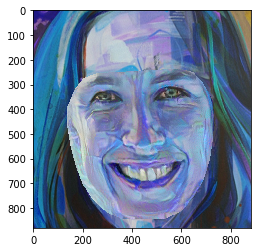

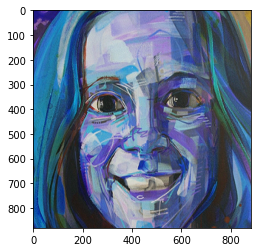

In [10]:
# compute the warped version of the headshot image
image1_warped = compute_warped_image(image1_cropped,image2_cropped,dt_image1,image1_points_final,image2_points_final)

plt.figure()
plt.imshow(image1_warped)
plt.figure()
plt.imshow(image2_cropped)

cv2.imwrite('files/warped_headshot_inpainted.jpg',image1_warped)

In [11]:
# try with smaller image


print(hullPoints_image2_small)
print(hullPoints_image2)

[(730, 439), (726, 516), (714, 599), (690, 681), (651, 754), (596, 814), (527, 844), (447, 844), (364, 844), (297, 817), (242, 765), (200, 703), (172, 628), (152, 551), (139, 474), (137, 394), (169, 318), (203, 275), (258, 255), (585, 237), (645, 250), (685, 293), (725, 363)]
[(771, 473), (770, 552), (761, 637), (740, 717), (699, 786), (640, 842), (572, 879), (481, 879), (389, 879), (314, 849), (254, 796), (213, 730), (191, 652), (176, 574), (166, 498), (166, 427), (199, 351), (224, 297), (275, 268), (612, 246), (671, 264), (710, 310), (765, 397)]


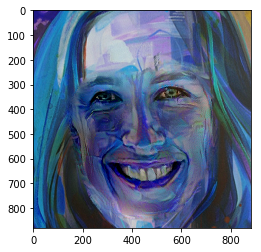

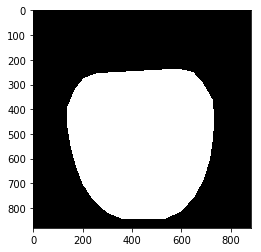

In [12]:
# compute the mask and clone into image
new_image, mask = clone_image(hullPoints_image2_small,image1_warped,image2_cropped)

plt.figure()
plt.imshow(new_image)
cv2.imwrite('files/warped_headshot_cloned.jpg',new_image)

plt.figure()
plt.imshow(mask)

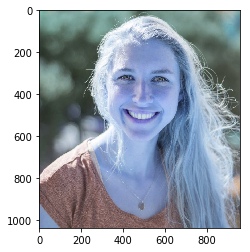

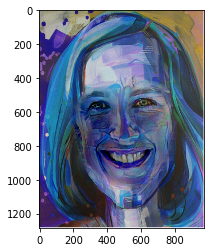

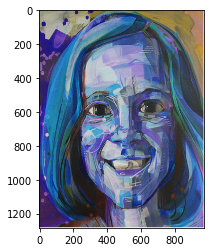

In [13]:
# place the cropped image back into the original art image
minx, miny, maxx, maxy = image2_rectangle 
blended_image = np.copy(image2_orig)
blended_image[miny:maxy, minx:maxx,:] = new_image

cv2.imwrite('files/warped_headshot_inserted1.jpg',blended_image)

original_image1  = cv2.imread(original_headshot,cv2.IMREAD_COLOR)

# plot things
plt.figure()
plt.imshow(original_image1)

plt.figure()
plt.imshow(blended_image)

plt.figure()
plt.imshow(image2)